# **Imports**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision

In [10]:
!pip install rebasin
!pip install torchview

from rebasin import PermutationCoordinateDescent
from rebasin import interpolation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Utility Functions**

In [2]:
def compute_accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    batch_accuracy = 0.0
    
    normalizedPreds = torch.nn.functional.softmax(logits, dim=1)
    batch_accuracy = torch.mean((labels == torch.argmax(normalizedPreds, dim = 1)) + 0.)

    return batch_accuracy

class AverageMeter(object):
    def __init__(self, name: str, fmt: str = ":f") -> None:
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self) -> None:
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)

# **DataLoader**

In [72]:
Batch_size = 32
num_epochs = 25
transform = transforms.Compose(
[transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

mnistTrainSet = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnistTrainSet, batch_size=Batch_size,
                                      shuffle=True)
mnistTestSet = torchvision.datasets.MNIST(root='./data', train=False,
                                    download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(mnistTestSet, batch_size=Batch_size,
                                      shuffle=True)

# **Visualizations**

In [74]:
def evaluateModel(model, input_dim, useTrain = False):
  loader = train_loader if useTrain else val_loader
  model.eval()
  val_loss_meter = AverageMeter("val loss")
  val_acc_meter = AverageMeter("val accuracy")
  with torch.no_grad():
    for pointI, (x, y) in enumerate((loader)):
        x = x.to(device).reshape([-1]+input_dim)
        y = y.to(device)

        activations = model(x)
        loss = criterion(activations, y.long())
        accuracy = compute_accuracy(activations, y.long())

        n = len(x)
        val_loss_meter.update(val=float(loss.cpu().item()), n=n)
        val_acc_meter.update(val=float(accuracy.cpu().item()), n=n)
    val_loss, val_acc = val_loss_meter.avg, val_acc_meter.avg

    return val_loss, val_acc

In [5]:
def weightAveragePerformancePlot(model1, model2, intervalSize, modelClass, useTrain = False, input_dim = [1, 28, 28], parametersForClassInit = []):
  model1.eval()
  model2.eval()

  loss, accuracy = [], []
  steps = list(np.arange(0, 1+intervalSize, intervalSize))
  for lambdaV in tqdm(steps):
    newModel = modelClass(*parametersForClassInit)
    for (p, p1, p2) in zip(newModel.parameters(), model1.parameters(), model2.parameters()):
      p.data = p1*(1-lambdaV) + p2 * lambdaV

    l, a = evaluateModel(newModel, input_dim, useTrain)
    loss.append(l)
    accuracy.append(a)

  fig, ax = plt.subplots(1,2, figsize=(15,5))
  fig.tight_layout()

  # Adding titles to subplots
  ax[0].set_title('Loss vs Linear Combination Coefficient Lambda')
  ax[1].set_title('Accuracy vs Linear Combination Coefficient Lambda')

  ax[0].set_xlabel('Lambda')
  ax[1].set_xlabel('Lambda')

  ax[0].set_ylabel('Loss')
  ax[1].set_ylabel('Accuracy')

  ax[0].plot(steps, loss)
  ax[1].plot(steps, accuracy)

  ax[0].set_xticks(steps)
  ax[1].set_xticks(steps)
  ax[1].set_yticks(steps)

  return loss, accuracy, steps, fig

# **MLP**

In [65]:
class MLP(nn.Module):
    def __init__(self): 
        super().__init__()

        self.layer1 = nn.Linear(28*28, 512)
        self.ReLU = nn.ReLU()
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 10)

    def forward(self, x):

        a1 = self.layer1(x)
        a2 = self.ReLU(a1)
        a3 = self.layer2(a2)
        a4 = self.ReLU(a3)
        a5 = self.layer3(a4)

        return a5
device="cpu"
lr = .0001/2

In [ ]:
model2 = MLP().to(device)
modelTrain = model2
optimizer = torch.optim.AdamW([{"params": modelTrain.parameters(), "lr": lr}])
#add multiple linear layers in aux loss
#Losses - focal loss, dice loss, fixing masked loss for auxilary ratios
criterion = nn.CrossEntropyLoss()

train_loss_history = []
train_accuracy_history =  []
validation_loss_history = []
validation_accuracy_history = []
"""Train for num_epochs, and validate after every epoch."""
for epoch_idx in range(num_epochs):
    modelTrain.train()

    train_loss_meter = AverageMeter("train loss")
    train_acc_meter = AverageMeter("train accuracy")
    vals = []
    for pointI, (x, y) in enumerate(tqdm(train_loader)):
        x = x.to(device).flatten(start_dim=1)
        y = y.to(device)

        activations = modelTrain(x)

        loss = criterion(activations, y.long())
        accuracy = compute_accuracy(activations, y.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        n = len(x)
        train_loss_meter.update(val=float(loss.cpu().item()), n=n)
        train_acc_meter.update(val=float(accuracy.cpu().item()), n=n)

    train_loss, train_acc = train_loss_meter.avg, train_acc_meter.avg
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_acc)
    
    
    modelTrain.eval()
    val_loss_meter = AverageMeter("val loss")
    val_acc_meter = AverageMeter("val accuracy")
    with torch.no_grad():
      for pointI, (x, y) in enumerate(tqdm(val_loader)):
            x = x.to(device).flatten(start_dim=1)
            y = y.to(device)

            activations = modelTrain(x)

            loss = criterion(activations, y.long())
            accuracy = compute_accuracy(activations, y.long())

            n = len(x)
            val_loss_meter.update(val=float(loss.cpu().item()), n=n)
            val_acc_meter.update(val=float(accuracy.cpu().item()), n=n)



    val_loss, val_acc  = val_loss_meter.avg, val_acc_meter.avg
    validation_loss_history.append(val_loss)
    validation_accuracy_history.append(val_acc)
        

    print(
        f"Epoch:{epoch_idx + 1}"
        + f" Train Loss:{train_loss:.4f}"
        + f" Val Loss: {val_loss:.4f}"
        + f" Train Accuracy: {train_acc:.4f}"
        + f" Validation Accuracy: {val_acc:.4f}"
    )

In [ ]:
plt.plot(np.arange(0,len(train_loss_history)), train_loss_history, label = "Train Loss")
plt.plot(np.arange(0,len(validation_loss_history)), validation_loss_history, label = "Validation Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0,len(train_accuracy_history)), train_accuracy_history, label = "Train Accuracy")
plt.plot(np.arange(0,len(validation_accuracy_history)), validation_accuracy_history, label = "Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
intervalSize = .1
useTrain = False
loss, accuracy, steps, fig = weightAveragePerformancePlot(model, model2, intervalSize, MLP, useTrain, [28*28])

In [85]:
class flatten():
    def __init__(self):
      return
    def __call__(self, x,):
        return x.reshape(-1)

transform = transforms.Compose(
[transforms.ToTensor(), transforms.Normalize((0.5), (0.5)), flatten()])

mnistTrainSetFlat = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
train_loaderFlat = torch.utils.data.DataLoader(mnistTrainSetFlat, batch_size=Batch_size,
                                      shuffle=True)

def eval_fn(model, model_device) -> float:
    loss = 0.0
    for inputs, y in train_loaderFlat:
        if model_device is not None:
            inputs = inputs.to(model_device)
            y = plt.ylabel.to(model_device)
        outputs = model(inputs)
        loss = criterion(outputs, y)
    return loss / len(train_loaderFlat)

input_data = next(iter(train_loaderFlat))[0]

#Changes model2 to the basin of model1
pcd = PermutationCoordinateDescent(model, model2, input_data)
pcd.calculate_permutations()
pcd.apply_permutations()

# **CNN**

In [100]:
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()

        self.layer1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (7,7), stride = 1, padding = 0)
        self.ReLU = nn.ReLU()
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (4,4), stride = 2, padding = 0)
        self.layer3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = 2, padding = 0)
        self.Pool = nn.AdaptiveAvgPool2d((1,1))
        self.layer4 = nn.Linear(64, 10)

    def forward(self, x):

        a1 = self.layer1(x)
        a2 = self.ReLU(a1)
        a3 = self.layer2(a2)
        a4 = self.ReLU(a3)
        a5 = self.layer3(a4)
        a6 = self.ReLU(a5)
        a7 = self.Pool(a6).flatten(start_dim=1)
        a8 = self.layer4(a7)

        return a1, a2, a3, a4, a5, a6, a7, a8
device="cpu"
lr = .0001/2

In [ ]:
#model = CNN().to(device)
modelTrain = model
optimizer = torch.optim.AdamW([{"params": modelTrain.parameters(), "lr": lr}])
#add multiple linear layers in aux loss
#Losses - focal loss, dice loss, fixing masked loss for auxilary ratios
criterion = nn.CrossEntropyLoss()

train_loss_history = []
train_accuracy_history =  []
validation_loss_history = []
validation_accuracy_history = []
"""Train for num_epochs, and validate after every epoch."""
for epoch_idx in range(num_epochs):
    modelTrain.train()

    train_loss_meter = AverageMeter("train loss")
    train_acc_meter = AverageMeter("train accuracy")
    vals = []
    for pointI, (x, y) in enumerate(tqdm(train_loader)):
        x = x.to(device)
        y = y.to(device)

        activations = modelTrain(x)

        loss = criterion(activations, y.long())
        accuracy = compute_accuracy(activations=, y.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        n = len(x)
        train_loss_meter.update(val=float(loss.cpu().item()), n=n)
        train_acc_meter.update(val=float(accuracy.cpu().item()), n=n)

    train_loss, train_acc = train_loss_meter.avg, train_acc_meter.avg
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_acc)
    
    
    modelTrain.eval()
    val_loss_meter = AverageMeter("val loss")
    val_acc_meter = AverageMeter("val accuracy")
    with torch.no_grad():
      for pointI, (x, y) in enumerate(tqdm(val_loader)):
            x = x.to(device)
            y = y.to(device)

            activations = modelTrain(x)

            loss = criterion(activations, y.long())
            accuracy = compute_accuracy(activations, y.long())

            n = len(x)
            val_loss_meter.update(val=float(loss.cpu().item()), n=n)
            val_acc_meter.update(val=float(accuracy.cpu().item()), n=n)



    val_loss, val_acc  = val_loss_meter.avg, val_acc_meter.avg
    validation_loss_history.append(val_loss)
    validation_accuracy_history.append(val_acc)
        

    print(
        f"Epoch:{epoch_idx + 1}"
        + f" Train Loss:{train_loss:.4f}"
        + f" Val Loss: {val_loss:.4f}"
        + f" Train Accuracy: {train_acc:.4f}"
        + f" Validation Accuracy: {val_acc:.4f}"
    )

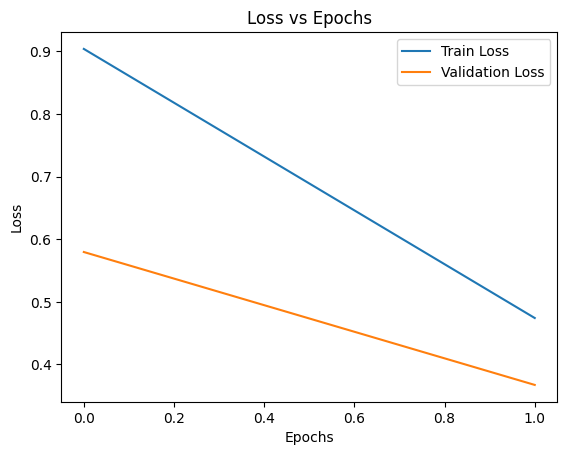

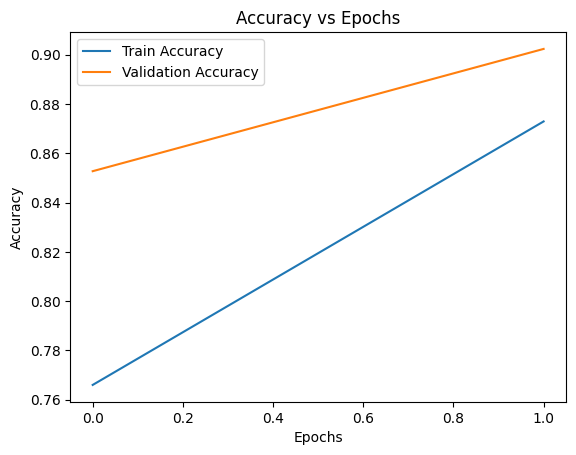

In [131]:
plt.plot(np.arange(0,len(train_loss_history)), train_loss_history, label = "Train Loss")
plt.plot(np.arange(0,len(validation_loss_history)), validation_loss_history, label = "Validation Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0,len(train_accuracy_history)), train_accuracy_history, label = "Train Accuracy")
plt.plot(np.arange(0,len(validation_accuracy_history)), validation_accuracy_history, label = "Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

100%|██████████| 11/11 [01:31<00:00,  8.28s/it]


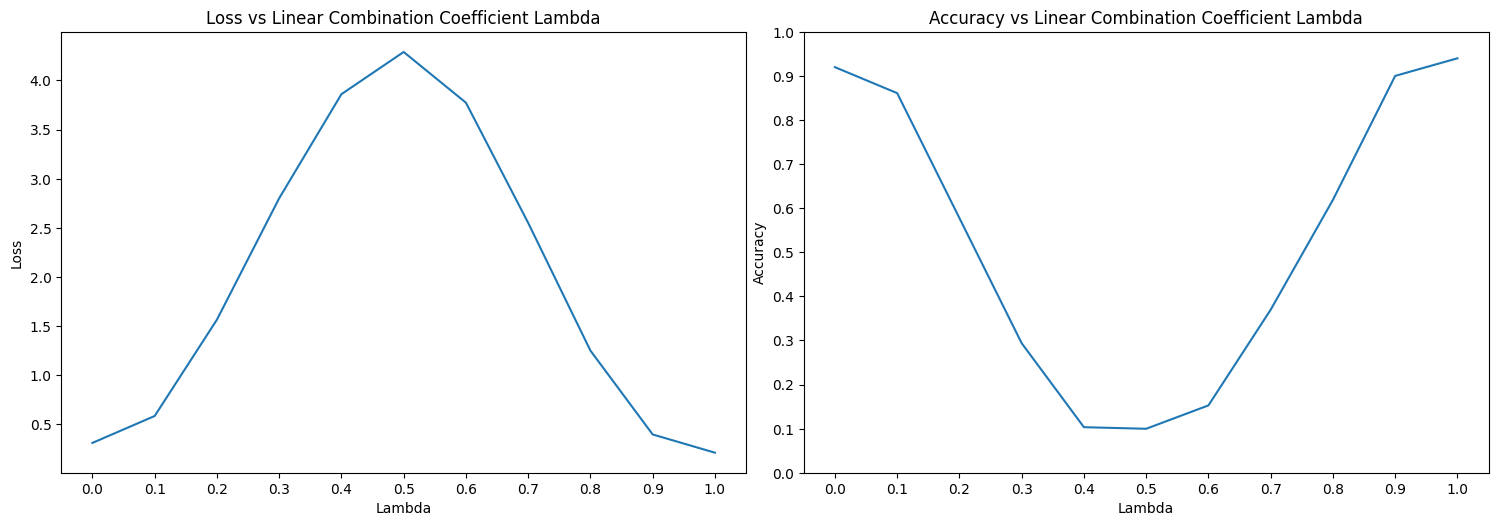

In [132]:
intervalSize = .1
useTrain = False
loss, accuracy, steps, fig = weightAveragePerformancePlot(model, model2, intervalSize, CNN, useTrain, [1,28,28])